In [1]:
import scanpy as sc
import decoupler as dc

# Solo necesitamos estas librerias para el procesamiento.
import numpy as np
import pandas as pd

In [2]:
# Descargamos los datos de la página single-cell expression atlas. 
datos = sc.datasets.ebi_expression_atlas("E-MTAB-10553", filter_boring=True)

datos

AnnData object with n_obs × n_vars = 17123 × 22813
    obs: 'Sample Characteristic[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Factor Value[inferred cell type - ontology labels]', 'Factor Value Ontology Term[inferred cell type - ontology labels]', 'Factor Value[inferred cell type - authors labels]', 'Factor Value Ontology Term[inferred cell type - authors labels]'

In [3]:
# Seleccionamos y cambiamos el nombre de las variables de interés para manejarlas mejor.
# Este es un paso recomendado en la biblioteca Scanpy.
columns  = ['Sample Characteristic[sex]',
           'Sample Characteristic[individual]',
           'Factor Value[inferred cell type - ontology labels]',
           'Sample Characteristic[age]']
datos.obs = datos.obs[columns]
datos.obs.columns  = ['sex','individual','cell_type','age']
datos.obs_names_make_unique()
datos.obs

,sex,individual,cell_type,age
SAMEA11294524-AAAACTCGTCCGAAGA,male,donor1,NaN,84 year
SAMEA11294524-AAACCTGAGTCTCCTC,male,donor1,hepatocyte,84 year
SAMEA11294524-AAACCTGCAATGTAAG,male,donor1,macrophage,84 year
SAMEA11294524-AAACCTGCACCGATAT,male,donor1,T cell,84 year
SAMEA11294524-AAACCTGCAGTAAGCG,male,donor1,NaN,84 year
...,...,...,...,...
SAMEA11294531-TTTGGTTCACGGTTTA,female,donor6,T cell,46 year
SAMEA11294531-TTTGGTTGTGACGCCT,female,donor6,NaN,46 year
SAMEA11294531-TTTGGTTTCCAAATGC,female,donor6,macrophage,46 year
SAMEA11294531-TTTGTCAAGATCTGCT,female,donor6,Kupffer cell,46 year


In [4]:
# Incorporamos los counts.
datos.layers['counts'] = datos.X
sc.pp.normalize_total(datos, target_sum=1e5)

# Aplicamos logaritmos.
sc.pp.log1p(datos)

# Normalizamos.
datos.layers['normalized'] = datos.X

C:\Users\pepi\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\pepi\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


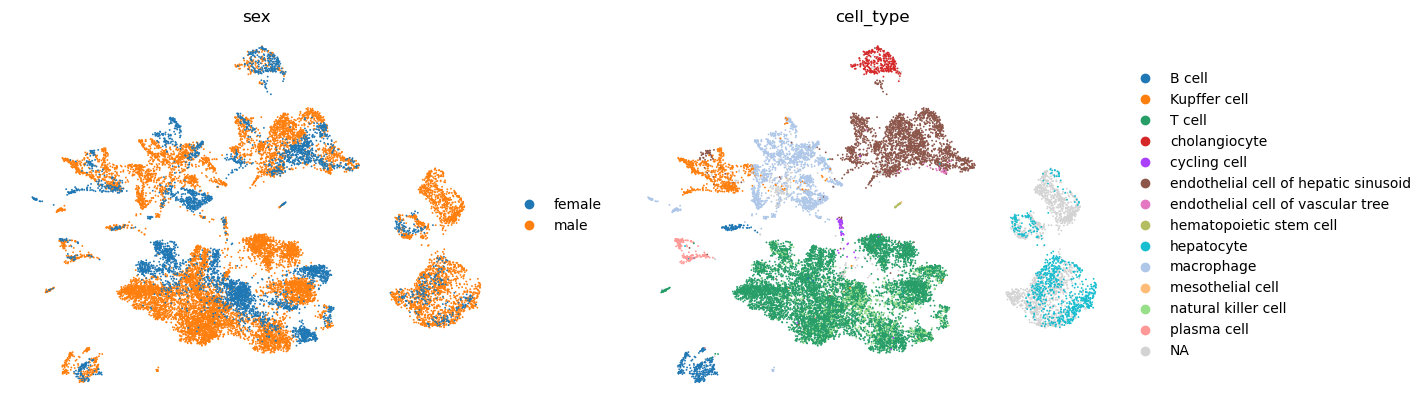

C:\Users\pepi\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\pepi\anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


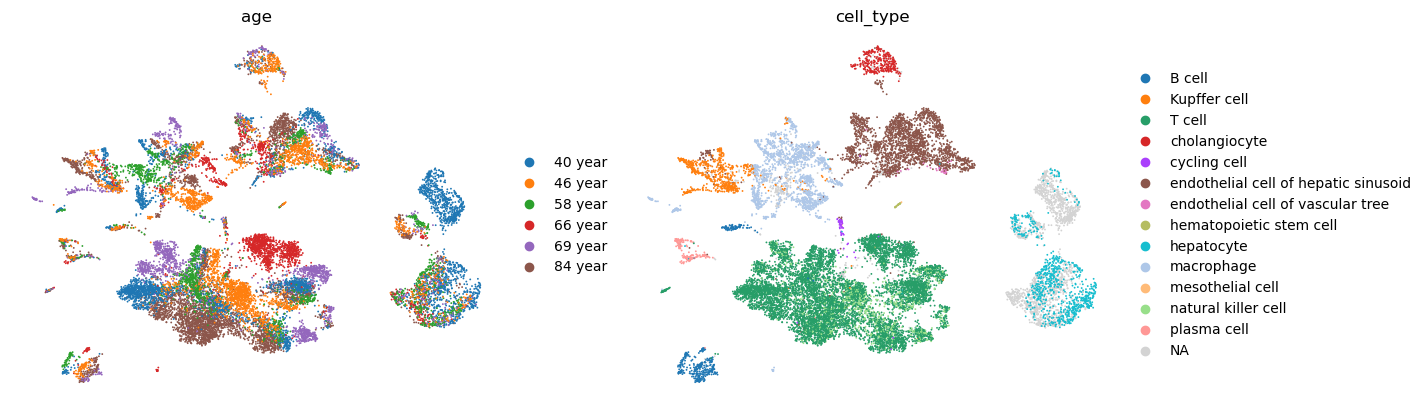

In [5]:
# Seleccionamos los altamente variables.
sc.pp.highly_variable_genes(datos)

# Escalamos.
sc.pp.scale(datos, max_value=10)

# Generemos PCAs.
sc.tl.pca(datos, svd_solver='arpack', use_highly_variable=True)

# Computamos las distancias dentro del espacio del PCA y encontramos los neighboards.
sc.pp.neighbors(datos)

# UMAP
sc.tl.umap(datos)

# Visualización del UMAP
sc.pl.umap(datos, color=['sex','cell_type'], frameon=False)
sc.pl.umap(datos, color=['age','cell_type'], frameon=False)

In [6]:
# Cambiamos de float a str para poder realizar el pseudobulk.
datos.obs['cell_type'] = datos.obs['cell_type'].astype(str)
datos.obs['sex'] = datos.obs['sex'].astype(str)
datos.obs['individual'] = datos.obs['individual'].astype(str)
datos.obs['age'] = datos.obs['age'].astype(str)

In [7]:
# Ahora hacemos el análisis pseudobulk pero para las distintas edades.
pdatos = dc.get_pseudobulk(datos,
                          sample_col='cell_type',
                          groups_col='age',
                          layer='counts',
                          mode='sum',
                          min_cells=0,
                          min_counts=0
                         )
pdatos

View of AnnData object with n_obs × n_vars = 77 × 9750
    obs: 'sex', 'individual', 'cell_type', 'age'

In [8]:
# Vemos que estan agrupadas según la edad y con la variable sexo.
pdatos.obs

,sex,individual,cell_type,age
B cell_40 year,male,donor2,B cell,40 year
Kupffer cell_40 year,male,donor2,Kupffer cell,40 year
T cell_40 year,male,donor2,T cell,40 year
cholangiocyte_40 year,male,donor2,cholangiocyte,40 year
cycling cell_40 year,male,donor2,cycling cell,40 year
...,...,...,...,...
hepatocyte_84 year,male,donor1,hepatocyte,84 year
macrophage_84 year,male,donor1,macrophage,84 year
nan_84 year,male,donor1,nan,84 year
natural killer cell_84 year,male,donor1,natural killer cell,84 year


In [9]:
# Nos quedamos solo con nuestros datos de interes que son los hepatocitos.
age_adata = pdatos[pdatos.obs['cell_type'] == 'hepatocyte'].copy()
age_adata.obs

,sex,individual,cell_type,age
hepatocyte_40 year,male,donor2,hepatocyte,40 year
hepatocyte_46 year,female,donor6,hepatocyte,46 year
hepatocyte_58 year,male,donor4,hepatocyte,58 year
hepatocyte_66 year,male,donor3,hepatocyte,66 year
hepatocyte_69 year,female,donor5,hepatocyte,69 year
hepatocyte_84 year,male,donor1,hepatocyte,84 year


In [10]:
import time
archivo = 'age_adata.h5ad'
age_adata.write_h5ad(archivo,compression='gzip')